## Rapid prototyping - to establish training pipeline and output visualization


Libraries

In [1]:
import os
import random
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary

Creating a very small subset of the dataset (which is already a subset)

In [1]:
sourceBaseRGB = "./places365SubsetRGB"
sourceBaseGray = "./places365SubsetGray"

protoBaseRGB = "./rapidProtoRGB"
protoBaseGray = "./rapidProtoGray"

splits = {
    "train": 1000,
    "val": 100,
    "test": 200
}

random.seed(42)

def resetDir(dirPath):
    if os.path.exists(dirPath):
        shutil.rmtree(dirPath)
    os.makedirs(dirPath)

def selectResizeAndCopyPair(sourceDirRGB, sourceDirGray, destDirRGB, destDirGray, numSamples, size):
    resetDir(destDirRGB)
    resetDir(destDirGray)

    files = [f for f in os.listdir(sourceDirRGB) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    selectedFiles = random.sample(files, numSamples)

    for f in selectedFiles:
        srcPathRGB = os.path.join(sourceDirRGB, f)
        dstPathRGB = os.path.join(destDirRGB, f)

        srcPathGray = os.path.join(sourceDirGray, f)
        dstPathGray = os.path.join(destDirGray, f)

        # RGB
        imgRGB = Image.open(srcPathRGB).convert("RGB")
        imgRGB = imgRGB.resize((size, size))
        imgRGB.save(dstPathRGB)

        # Gray
        imgGray = Image.open(srcPathGray).convert("L")
        imgGray = imgGray.resize((size, size))
        imgGray.save(dstPathGray)

for split, numImages in splits.items():
    rgbSourceDir = os.path.join(sourceBaseRGB, split)
    graySourceDir = os.path.join(sourceBaseGray, split)

    rgbDestDir = os.path.join(protoBaseRGB, split)
    grayDestDir = os.path.join(protoBaseGray, split)

    selectResizeAndCopyPair(rgbSourceDir, graySourceDir, rgbDestDir, grayDestDir, numImages, size=64)

    print(f"Completed {split}: {numImages} paired, resized images copied.")

print("Rapid prototyping dataset created: 64x64 images in rapidProtoRGB and rapidProtoGray.")


Completed train: 1000 paired, resized images copied.
Completed val: 100 paired, resized images copied.
Completed test: 200 paired, resized images copied.
Rapid prototyping dataset created: 64x64 images in rapidProtoRGB and rapidProtoGray.


Visualizing the datasets

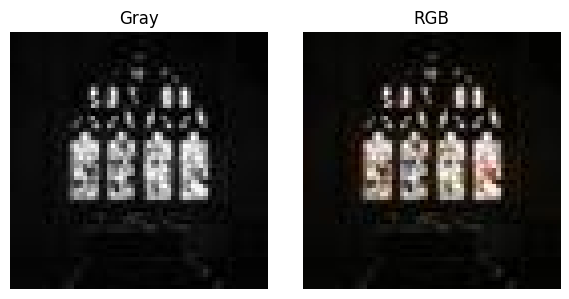

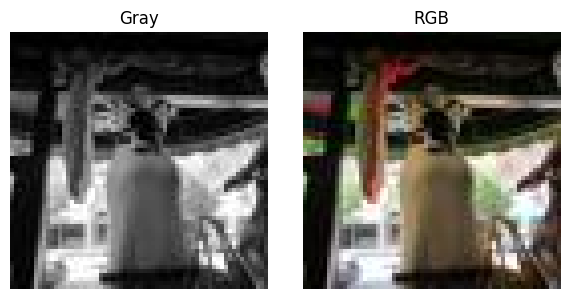

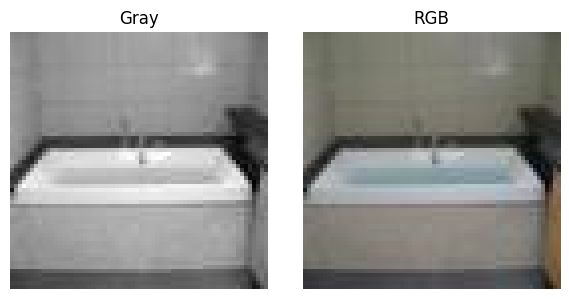

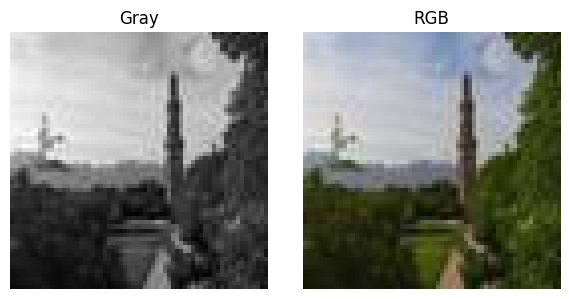

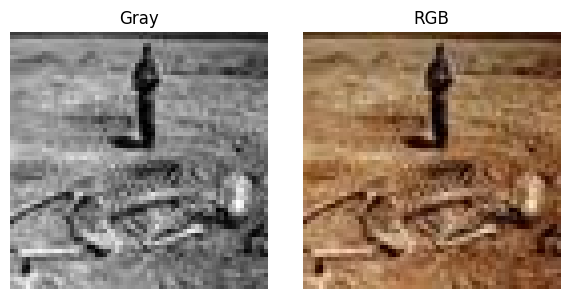

In [ ]:
grayDir = "./rapidProtoGray/train"
rgbDir = "./rapidProtoRGB/train"

# Get list of files
files = [f for f in os.listdir(grayDir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select 3 files
sampleFiles = random.sample(files, 3)

for fname in sampleFiles:
    grayPath = os.path.join(grayDir, fname)
    rgbPath = os.path.join(rgbDir, fname)

    grayImg = Image.open(grayPath).convert("L")
    rgbImg = Image.open(rgbPath).convert("RGB")

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(grayImg, cmap='gray')
    axes[0].set_title("Gray")
    axes[0].axis("off")

    axes[1].imshow(rgbImg)
    axes[1].set_title("RGB")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


#### <b>Vanilla U-Net model</b>

In [2]:
class UNetBlock(nn.Module):
    def __init__(self, inChannels, outChannels):
        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(outChannels)
        self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(outChannels)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class UNet(nn.Module):
    def __init__(self, inChannels=1, outChannels=3):
        super(UNet, self).__init__()
        self.enc1 = UNetBlock(inChannels, 64)
        self.enc2 = UNetBlock(64, 128)
        self.enc3 = UNetBlock(128, 256)
        self.enc4 = UNetBlock(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = UNetBlock(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = UNetBlock(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = UNetBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = UNetBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = UNetBlock(128, 64)

        self.finalConv = nn.Conv2d(64, outChannels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.up4(m)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.finalConv(d1)
        return out

In [3]:
vanillaUNET = UNet()
summary(vanillaUNET)

Layer (type:depth-idx)                   Param #
UNet                                     --
├─UNetBlock: 1-1                         --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─Conv2d: 2-3                       36,928
│    └─BatchNorm2d: 2-4                  128
├─UNetBlock: 1-2                         --
│    └─Conv2d: 2-5                       73,856
│    └─BatchNorm2d: 2-6                  256
│    └─Conv2d: 2-7                       147,584
│    └─BatchNorm2d: 2-8                  256
├─UNetBlock: 1-3                         --
│    └─Conv2d: 2-9                       295,168
│    └─BatchNorm2d: 2-10                 512
│    └─Conv2d: 2-11                      590,080
│    └─BatchNorm2d: 2-12                 512
├─UNetBlock: 1-4                         --
│    └─Conv2d: 2-13                      1,180,160
│    └─BatchNorm2d: 2-14                 1,024
│    └─Conv2d: 2-15                      2,359,808
│    └─BatchNorm2d: 2-16

Loading dataset as tensors

In [4]:
class ColorizationDataset(Dataset):
    def __init__(self, grayDir, rgbDir):
        self.grayDir = grayDir
        self.rgbDir = rgbDir
        self.filenames = [f for f in os.listdir(grayDir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        self.grayTransform = transforms.Compose([
            transforms.ToTensor(),  # (1, H, W) after grayscale
        ])

        self.rgbTransform = transforms.Compose([
            transforms.ToTensor(),  # (3, H, W)
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        grayPath = os.path.join(self.grayDir, fname)
        rgbPath = os.path.join(self.rgbDir, fname)

        grayImg = Image.open(grayPath).convert("L")
        rgbImg = Image.open(rgbPath).convert("RGB")

        grayTensor = self.grayTransform(grayImg)
        rgbTensor = self.rgbTransform(rgbImg)

        return grayTensor, rgbTensor


Training loop

In [9]:
# Directories
trainGrayDir = "./rapidProtoGray/train"
trainRgbDir = "./rapidProtoRGB/train"
valGrayDir = "./rapidProtoGray/val"
valRgbDir = "./rapidProtoRGB/val"

# Dataset and dataloader
trainDataset = ColorizationDataset(trainGrayDir, trainRgbDir)
valDataset = ColorizationDataset(valGrayDir, valRgbDir)

trainLoader = DataLoader(trainDataset, batch_size=8, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=8, shuffle=False)

# Model
model = UNet(inChannels=1, outChannels=3)
model = model.cuda()  # If using GPU

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
numEpochs = 20  # Prototype quick run

for epoch in range(numEpochs):
    model.train()
    trainLoss = 0.0

    for gray, rgb in trainLoader:
        gray = gray.cuda()
        rgb = rgb.cuda()

        optimizer.zero_grad()
        output = model(gray)
        loss = criterion(output, rgb)
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()

    avgTrainLoss = trainLoss / len(trainLoader)

    model.eval()
    valLoss = 0.0

    with torch.no_grad():
        for gray, rgb in valLoader:
            gray = gray.cuda()
            rgb = rgb.cuda()

            output = model(gray)
            loss = criterion(output, rgb)
            valLoss += loss.item()

    avgValLoss = valLoss / len(valLoader)

    print(f"Epoch [{epoch+1}/{numEpochs}], Train Loss: {avgTrainLoss:.4f}, Val Loss: {avgValLoss:.4f}")

print("Training completed.")


Epoch [1/20], Train Loss: 0.0404, Val Loss: 0.0092
Epoch [2/20], Train Loss: 0.0109, Val Loss: 0.0071
Epoch [3/20], Train Loss: 0.0092, Val Loss: 0.0065
Epoch [4/20], Train Loss: 0.0085, Val Loss: 0.0065
Epoch [5/20], Train Loss: 0.0087, Val Loss: 0.0060
Epoch [6/20], Train Loss: 0.0081, Val Loss: 0.0058
Epoch [7/20], Train Loss: 0.0076, Val Loss: 0.0059
Epoch [8/20], Train Loss: 0.0080, Val Loss: 0.0060
Epoch [9/20], Train Loss: 0.0073, Val Loss: 0.0054
Epoch [10/20], Train Loss: 0.0077, Val Loss: 0.0056
Epoch [11/20], Train Loss: 0.0071, Val Loss: 0.0054
Epoch [12/20], Train Loss: 0.0072, Val Loss: 0.0057
Epoch [13/20], Train Loss: 0.0067, Val Loss: 0.0057
Epoch [14/20], Train Loss: 0.0069, Val Loss: 0.0056
Epoch [15/20], Train Loss: 0.0067, Val Loss: 0.0052
Epoch [16/20], Train Loss: 0.0065, Val Loss: 0.0053
Epoch [17/20], Train Loss: 0.0061, Val Loss: 0.0052
Epoch [18/20], Train Loss: 0.0065, Val Loss: 0.0051
Epoch [19/20], Train Loss: 0.0063, Val Loss: 0.0058
Epoch [20/20], Train 

Output visualization

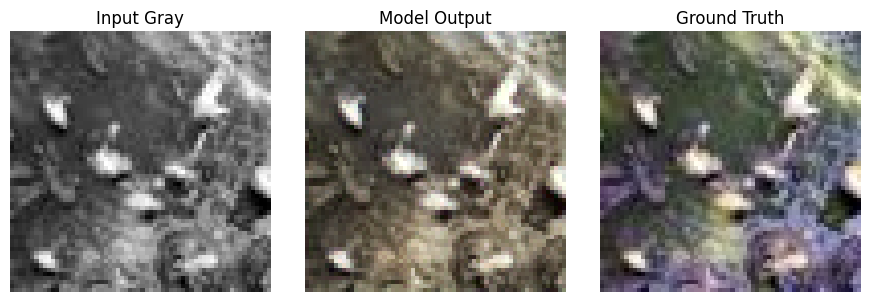

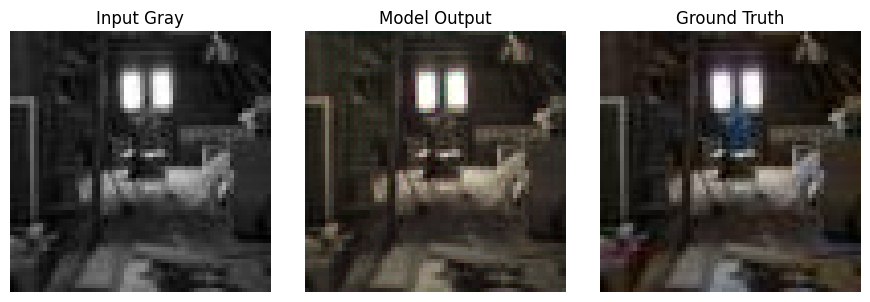

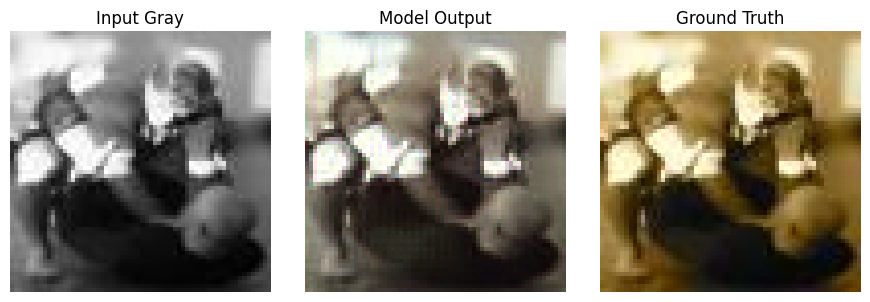

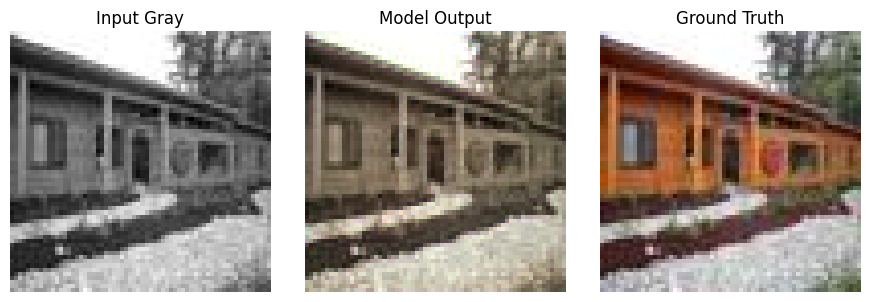

In [13]:
# Test directories
testGrayDir = "./rapidProtoGray/test"
testRgbDir = "./rapidProtoRGB/test"

# Prepare test dataset and loader
testDataset = ColorizationDataset(testGrayDir, testRgbDir)
testLoader = DataLoader(testDataset, batch_size=4, shuffle=True)

model.eval()

with torch.no_grad():
    for grayBatch, rgbBatch in testLoader:
        grayBatch = grayBatch.cuda()
        rgbBatch = rgbBatch.cuda()

        outputs = model(grayBatch)
        outputs = torch.clamp(outputs, 0, 1)

        # Move to CPU for visualization
        grayBatch = grayBatch.cpu()
        outputs = outputs.cpu()
        rgbBatch = rgbBatch.cpu()

        for i in range(min(4, grayBatch.size(0))):
            grayImg = grayBatch[i][0]  # (64, 64)
            outputImg = outputs[i].permute(1, 2, 0)  # (3, 64, 64) -> (64, 64, 3)
            gtImg = rgbBatch[i].permute(1, 2, 0)

            fig, axes = plt.subplots(1, 3, figsize=(9, 3))
            axes[0].imshow(grayImg, cmap="gray")
            axes[0].set_title("Input Gray")
            axes[0].axis("off")

            axes[1].imshow(outputImg)
            axes[1].set_title("Model Output")
            axes[1].axis("off")

            axes[2].imshow(gtImg)
            axes[2].set_title("Ground Truth")
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

        break  # Remove this if you'd like to continue through all test batches
